#### Relative permeability simulation using OpenPNM

* PNM extraction --> Define boundaries of PNM --> Stokes flow simulation --> Simulation data calibration
* Flow simulation considering not trapping

In [1]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)
im = np.load('1.npy')

snow = ps.networks.snow2(
    phases=im,
    phase_alias={True:"void",False:"solid"},
    voxel_size=2.32e-06)

ws = op.Workspace()
pn = op.io.network_from_porespy(snow.network)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
proj = pn.project

# add boundary pores
min_coor = pn['pore.coords'].min()
max_coor = pn['pore.coords'].max()

def marker_arr(min_value,max_value,boundary='left'):

    if boundary == 'left':
        marker = [
                min_value,
                random.uniform(min_value,max_value),
                random.uniform(min_value,max_value)
                ]

    if boundary == "right":
        marker = [
        max_value,
        random.uniform(min_value,max_value),
        random.uniform(min_value,max_value)
        ]
    
    return marker


left_marker = [marker_arr(min_coor,max_coor) for _ in range(20)]
right_marker = [marker_arr(min_coor,max_coor,'right') for _ in range(20)]
left_marker = np.array(left_marker)
right_marker = np.array(right_marker)

op.topotools.find_surface_pores(network=pn, markers=left_marker, label='left')
op.topotools.find_surface_pores(network=pn, markers=right_marker, label='right')
# %% Invasion Percolation
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('left')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/764 [00:00<?, ?it/s]

#### Kr simulation

In [2]:
def sat_occ_update(network, nwp, wp, ip, i):
    r"""
        Calculates the saturation of each phase using the invasion
        sequence from either invasion percolation.
        Parameters
        ----------
        network: network
        nwp : phase
            non-wetting phase
        wp : phase
            wetting phase
        ip : IP
            invasion percolation (ran before calling this function)
        i: int
            The invasion_sequence limit for masking pores/throats that
            have already been invaded within this limit range. The
            saturation is found by adding the volume of pores and thorats
            that meet this sequence limit divided by the bulk volume.
    """
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('left')
flow_out = pn.pores('right')
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
# %%
Snwp_num=100
flow_in = pn.pores('left')
flow_out = pn.pores('right')
max_seq = np.max([np.max(ip['pore.invasion_sequence']),
          np.max(ip['throat.invasion_sequence'])])
start = 0
stop = max_seq
step = max_seq//Snwp_num
Snwparr = []
relperm_nwp = []
relperm_wp = []

for i in range(start, stop, step):
    air.regenerate_models()
    water.regenerate_models()
    sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=i)
    Snwparr.append(sat)
    Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
    Rate_enwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    Rate_ewp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.conduit_hydraulic_conductance')
    relperm_nwp.append(Rate_enwp/Rate_abs_nwp)
    relperm_wp.append(Rate_ewp/Rate_abs_wp)


#### Plot kr curves

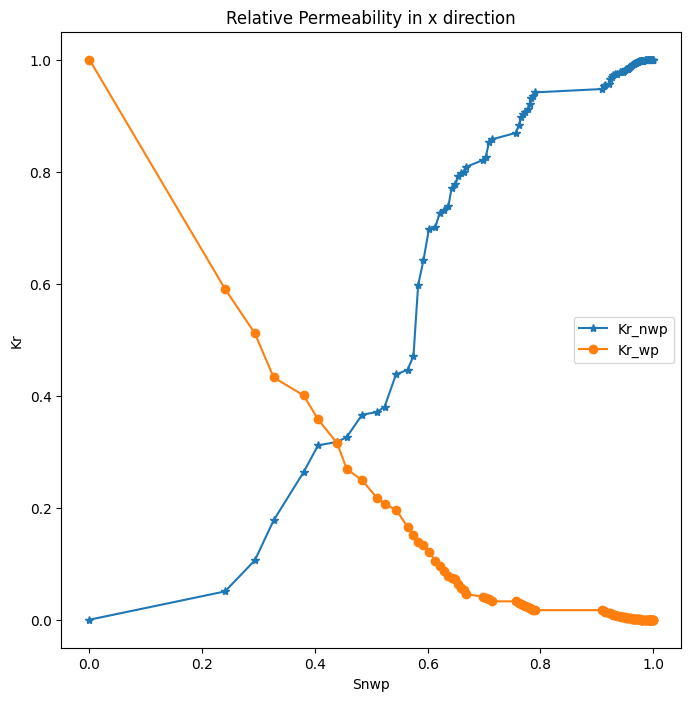

In [3]:
plt.figure(figsize=[8,8])
plt.plot(Snwparr, relperm_nwp, '*-', label='Kr_nwp')
plt.plot(Snwparr, relperm_wp, 'o-', label='Kr_wp')
plt.xlabel('Snwp')
plt.ylabel('Kr')
plt.title('Relative Permeability in x direction')
plt.legend()

In [4]:
import pandas as pd

kr_data = {
    'snwp':Snwparr,
    'krnw':np.array(relperm_nwp).flatten(),
    'krw':np.array(relperm_wp).flatten()
    }

kr_data_df = pd.DataFrame(kr_data)

#### Add wetting phase relative permeability threshold to determine under what condition the wetting and non-wetting phase stop flowing anymore

In [5]:
# kr_data_df_ft = kr_data_df[ ( (kr_data_df['krnw']>0.0001) & (kr_data_df['krw']>0.0001) ) ]
kr_data_df_ft = kr_data_df[ (kr_data_df['krw']>0.03) ]

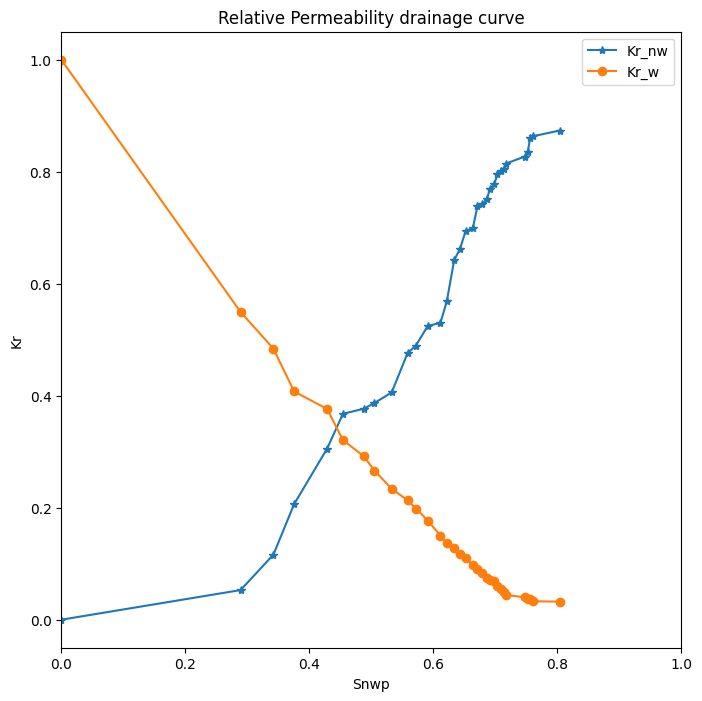

In [6]:
plt.figure(figsize=[8,8])
plt.plot(kr_data_df_ft['snwp'], kr_data_df_ft['krnw'], '*-', label='Kr_nw')
plt.plot(kr_data_df_ft['snwp'], kr_data_df_ft['krw'], 'o-', label='Kr_w')
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')
plt.title('Relative Permeability drainage curve')
plt.legend()